In [32]:
%matplotlib inline
from operator import xor
from tkinter.messagebox import YES

from matplotlib.colors import Normalize
from matplotlib import cm
from calculate_k_b import Calibration_mass
import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.interpolate as spi
from obspy.signal.detrend import polynomial
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.style.use('seaborn-poster')
import h5py
import pathlib as pl
import os
#from pynufft import NUFFT

my_path = os.getcwd()

mpl.rcParams['lines.linewidth'] = 1
plt.rcParams["font.family"] = "arial"
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.rm'] = 'Arial'

SMALL_SIZE = 22
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


class FFT_ionS():

    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[17,18], cal_pixel=[60,61]):
    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[1,2], cal_pixel=[100,244]):
    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[17,18], cal_pixel=[197,279]):
    #def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[1,16], cal_pixel=[243,1281]):
    def __init__(self, filename, massRange=[5, 50], dcRange=2, cal_mass=[2,16], cal_pixel=[6203,20525]):
        '''

        '''
        
        self.filename = filename
        self.channelSize = 24000#24000#1536
        self.scanLength = 1200#1200
        self.peakRange = [-50, 50]  # range of the peak
        self.delay = np.arange(self.scanLength)/self.scanLength*(10.0/11.2)*3478/3648*100*2*2*3.33564*10**-15
        self.rebin_delay = None
        self.ifrebin = False
        self.longstage = True
        self.data = 0
        self.massRange = massRange
        self.dcRange = dcRange
        self.windowSize = 100
        self.calculator = Calibration_mass(cal_mass, cal_pixel)
        self.gasBottle = {
            #"8": self.calculator.cal_pixel(8) + self.peakRange,
            #"45": self.calculator.cal_pixel(45) + self.peakRange,
            #"60": self.calculator.cal_pixel(60) + self.peakRange,
            #"CH3OH+": self.calculator.cal_pixel(32) + self.peakRange,
            #"CH2OH+": self.calculator.cal_pixel(31) + self.peakRange,
            #"CHOH+": self.calculator.cal_pixel(30) + self.peakRange,
            #"CHO+": self.calculator.cal_pixel(29) + self.peakRange,
            #"CO+":self.calculator.cal_pixel(28) +self.peakRange,
            #"CH2+":self.calculator.cal_pixel(14) +self.peakRange,
            #"CH3+":self.calculator.cal_pixel(15) +self.peakRange,
            # "N": self.calculator.cal_pixel(14) +self.peakRange,
            #"O+": self.calculator.cal_pixel(16)+self.peakRange,
            #"H2O+": self.calculator.cal_pixel(18)+self.peakRange,
            # "N2": self.calculator.cal_pixel(28)+self.peakRange,
            # "$O_2$": self.calculator.cal_pixel(32)+self.peakRange,
            # "N": self.calculator.cal_pixel(14) +self .peakRange,
            "O+": self.calculator.cal_pixel(16)+self.peakRange,
            #"H2O+": self.calculator.cal_pixel(18)+self.peakRange,
            #"OH+": self.calculator.cal_pixel(17)+self.peakRange,
            # "N2": self.calculator.cal_pixel(28)+self.peakRange,
            # "O2": self.calculator.cal_pixel(32)+self.peakRange,
            # "Ar": self.calculator.cal_pixel(32)+self.peakRange,
            #"H+": self.calculator.cal_pixel(1)+self.peakRange,
            "H2+": self.calculator.cal_pixel(2)+self.peakRange,
            "O+H2": #[0,self.channelSize]
            np.append(self.calculator.cal_pixel(16) + self.peakRange, self.calculator.cal_pixel(2) + self.peakRange),
            #"\'15+\'  +  \'H+\'": #[0,self.channelSize]
            #np.append(self.calculator.cal_pixel(16) + self.peakRange, self.calculator.cal_pixel(15) + self.peakRange),
            "O-H2": #[0,self.channelSize]
            np.append(np.append(self.calculator.cal_pixel(16) + self.peakRange, self.calculator.cal_pixel(2) + self.peakRange), 0),
            #'test':self.calculator.cal_pixel(1.5)+self.peakRange,
            #"\'CH3OH+\'-\'CH2OH+\'": #[0,self.channelSize]
            #np.append(self.calculator.cal_pixel(17) + self.peakRange, self.calculator.cal_pixel(18) + self.peakRange),
            #"\'CH3OH+\'+\'CH2OH+\'": #[0,self.channelSize]
            #np.append(np.append(self.calculator.cal_pixel(17) + self.peakRange, self.calculator.cal_pixel(18) + self.peakRange),0),
        }
        self.spectraBottle = {}
        self.fftS = {}
        self.stftS = {}
        self.spec = None
        self.scanNo = None

    def checkData(self):
        for filename in self.filename:
            with h5py.File(filename, 'r+') as f:
                print(np.array(f['parameters']))

                bigger = True
                i = 0
                while bigger:
                    try:
                        a = f['data'][i*self.channelSize,0]
                        i+=1
                    except ValueError:
                        bigger = False
                        self.scanNo = i
                        f.create_dataset('scanNo', data=i)
                        print('The number of scan is '+str(i)+'!')
    def read_multi(self):
        for file in self.filename:
            
            with h5py.File(file, 'r+') as f:
                self.data=self.data+np.array(f['useful'])

    def read_split(self, overNight = False, firstTry = False, sumNo = 20, usefulRange = [0, 5], cu = False):
        for filename in self.filename:
            with h5py.File(filename, 'r+') as f:
                print(np.array(f['data'].shape))
                #plt.plot(np.sum(np.array(f['data'][164*self.channelSize:(164+1)*self.channelSize]),0))
                #print('the pump-only count is '+str(np.sum(np.array(f['data'][164*self.channelSize:(164+1)*self.channelSize]))/116.7),'\nthe probe-only count is '+str(np.sum(np.array(f['data'][165*self.channelSize:(165+1)*self.channelSize]))/116.7) )
                #plt.show()
                print(f.keys())
                #print(np.array(f['ppNum']))
                #self.spec=np.array(f['spectrumLog'])
                dataSet_created={}
                if ('scanNo' in f):
                    self.scanNo = np.array(f['scanNo'], dtype=int)
                else:
                    self.checkData()
                if overNight:
                    splitNo = int(self.scanNo/sumNo)
                    for i in range(splitNo):
                        dataSet_created['sum'+str(i)]=[i*sumNo, (i+1)*sumNo]
                else:
                    dataSet_created = {'sum0':[0,self.scanNo-1]}
                for s in dataSet_created.keys():
                    e = s in f
                    if e and (not firstTry):
                        print('dataset \''+ s +'\' exists!!!')
                        pass
                    else:

                        print('Begin to create dataset \''+ s +'\'!')
                        data = np.zeros((self.channelSize, self.scanLength))
                        for i in range(dataSet_created[s][1],dataSet_created[s][0],-1):
                            try:
                                data = data + \
                                    np.array(f['data'][i*self.channelSize:(i+1)*self.channelSize])
                            except ValueError:
                                break
                        try:
                            f.create_dataset(s, data=data, compression="gzip") #create dataset 'sum'
                            print('Dataset \''+ s +'\' is created!')
                        except RuntimeError:
                            print('Dataset \''+ s +'\''+' already exists!')
                            try:
                                del f[s]
                                f[s] = data
                                print('Dataset \'' + s + '\''+' is overwrited!')
                            except RuntimeError:
                                print('Fail to overwrite dataset \'' + s + '\' !')
                if overNight and 'useful' in f and not firstTry and not cu:
                    self.data = np.array(f['useful'])
                    print(np.array(f['useful_description']))
                else:
                    dataSet_use = ['sum'+str(i) for i in range(usefulRange[0],usefulRange[1])]#[x for x in dataSet_created.keys()]
                    print('Now the dataset \'',  dataSet_use, '\' is in use!')
                    for d in dataSet_use:
                        self.data = self.data + np.array(f[d])
                    try:
                        f.create_dataset('useful', data=self.data) #create dataset 'sum'
                        useful_description = 'Sum of trace in range '+str((np.array(usefulRange)-[0,1])*sumNo)+' is in use!'
                        print(useful_description)
                        f.create_dataset('useful_description', data=useful_description) #create dataset 'sum'
                        print('Dataset \''+ 'useful' +'\' is created!')
                    except RuntimeError:
                        print('Dataset \''+ 'useful' +'\''+' already exists!')
                        if cu:
                            del f['useful']
                            print('Begin to overwrite dataset \''+ 'useful' +'\''+'!')
                            f['useful'] = self.data

    def FFT(self, t, y):
        n = len(t)
        delta = (max(t) - min(t)) / (n-1)
        k = int(n/2)
        f = np.arange(k) / (n*delta) / 10**12  # frequency unit THz
        Y = abs(sp.fft.fft(y))[:k]
        return np.array([f, Y])

    def mass_spectra(self):

        for gas in self.gasBottle.keys():
            if len(self.gasBottle[gas])==2:
                [pixelMin, pixelMax] = list(map(int, self.gasBottle[gas]))
                print(pixelMin, pixelMax)
                inter= np.sum(
                    self.data[pixelMin:pixelMax, :], 0)
                self.spectraBottle[gas] = inter
            elif len(self.gasBottle[gas])==4:
                [pixel0, pixel1, pixel2, pixel3] = list(map(int, self.gasBottle[gas]))
                inter1=np.sum(self.data[pixel0:pixel1, :], 0)
                inter2=np.sum(self.data[pixel2:pixel3, :], 0)
                self.spectraBottle[gas] =np.abs(inter1 + inter2)
                print('Sum two mass!!')
            elif len(self.gasBottle[gas])==5:
                [pixel0, pixel1, pixel2, pixel3, useless] = list(map(int, self.gasBottle[gas]))
                inter1=np.sum(self.data[pixel0:pixel1, :], 0)
                inter2=np.sum(self.data[pixel2:pixel3, :], 0)
                self.spectraBottle[gas] =np.abs(inter1 - inter2)
                print('Sub two mass!!')


    def window(self, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        for gas in self.spectraBottle.keys():
            if 'rebin' not in gas:
                self.spectraBottle[gas], self.delay = self.inter_window(gas, self.delay, windowSize=windowSize, direction=direction)
            else:
                self.spectraBottle[gas], self.rebin_delay = self.inter_window(gas, self.rebin_delay, windowSize=windowSize, direction=direction)
            
    def inter_window(self, gas, delay, windowSize=0, direction='left'):
        '''
        windowSize is in fs.
        '''
        data = self.spectraBottle[gas]
        __len = np.size(data)
        windowSize = int(windowSize/(delay[1]-delay[0])*1e-15) 
        if direction == 'left':
            window = data[-(__len-windowSize):]
            delay = delay[-(__len-windowSize):]
        elif direction == 'right':
            window = data[:__len-windowSize]
            delay = delay[:__len-windowSize]
        elif direction == 'middle':
            window = np.concatenate((
                data[:round((__len-windowSize)/2)],  # need to check again
                (data[round((__len-windowSize)/2)] + \
                 data[round((__len+windowSize)/2)])/2*(np.zeros(windowSize)+1),
                data[-(__len-round((__len+windowSize)/2)+1):]
            ))
            #self.paddedDelay = np.arange(self.delay[0])
        # if (stepNum_left%2) == 0:
        #    paddingWindow = np.concatenate(( np.zeros(int(stepNum_left/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int(stepNum_left/2))+1,np.zeros(paddingSize)))
        #    #self.paddedDelay = np.arange(self.delay[0])
        # else:
        #    paddingWindow = np.concatenate((np.zeros(paddingSize), np.zeros(int((stepNum_left-1)/2))+1,
        #    np.zeros(windowSize*2),np.zeros(int((stepNum_left+1)/2))+1, np.zeros(paddingSize)))
            # plt.plot(dcShift)
        window=polynomial(window, order=3, plot=False)
        hwindow = np.hanning(len(window))#sps.windows.flattop(len(window),sym=FALSE)
        window2=window*hwindow
        return window2, delay

    def padding(self, paddingSize=0):
        for gas in self.spectraBottle.keys():
            if "rebin" not in gas:
                self.spectraBottle[gas], self.delay = self.inter_padding(gas, self.delay, paddingSize = paddingSize)
            else:
                self.spectraBottle[gas], self.rebin_delay = self.inter_padding(gas, self.rebin_delay, paddingSize = paddingSize)

    def inter_padding(self, gas, delay, paddingSize=0):
        data = None
        delayStep = delay[90]-delay[89]
        delay = np.concatenate((
            #np.arange(delay[0]-(paddingSize+1) *
            #          delayStep, delay[0], delayStep),
            delay,
            np.arange(delay[-1]+delayStep, delay[-1] +
                      (paddingSize)*delayStep, delayStep)
        ))
        inter_data = self.spectraBottle[gas]
        data = np.concatenate(
            #(np.zeros(paddingSize)+inter_data[0], inter_data, np.zeros(paddingSize)+inter_data[-1]), axis=0)
            (inter_data, (np.zeros(paddingSize))), axis=0)
        delay = delay[:len(data)]
        #data=data[:len(delay)]
        return data, delay

        

    def interpS(self, interNum=1):
        interpDelay = np.arange(
            self.delay[0], self.delay[-1], (self.delay[1]-self.delay[0])/(interNum+1))
        for gas in self.spectraBottle.keys():
            iS = np.interp(interpDelay, self.delay, self.spectraBottle[gas])
            self.spectraBottle[gas] = iS
            # print(np.shape(iS))
        self.delay = interpDelay
        # print(np.sie(self.delay))

    def FFTS(self):
        for gas in self.spectraBottle.keys():
            if self.ifrebin:
                if "rebin" not in gas:
                    continue
                else:
                    delay = self.rebin_delay
                    self.fftS[gas] = self.FFT(
                        delay, self.spectraBottle[gas][self.windowSize::])
            else:
                if "rebin" not in gas:
                    delay = self.delay
                    self.fftS[gas] = self.FFT(
                        delay, self.spectraBottle[gas][self.windowSize::])
                else:
                    continue

    # def filterS(self, band):
     #   for gas in self.spectraBottle.keys():
      #      N, wn = sps.buttord(1e11, )
       #     fil = sps.butter(10, band, btype='band', fs=1000, output='sos')
        #    self.spectraBottle[gas] = sps.sosfilt(fil, self.spectraBottle[gas])

    def STFTS(self, windowsize=0, ratio=10):
        '''
        windowsize is window size in fs
        '''
        for gas in self.spectraBottle.keys():
            #if 'rebin' not in gas or 'filter' not in gas:
            if 'rebin' not in gas:
                continue
            f, t, self.stftS[gas] = sps.stft(self.spectraBottle[gas], fs=1/(
                self.rebin_delay[2]-self.rebin_delay[1]), noverlap=windowsize-2, nperseg=windowsize, nfft=windowsize*3)
            #self.stftS[gas] = self.stftS[gas][:,::-1]*10
            self.stftS[gas] = self.stftS[gas]*10
            vmax=abs(self.stftS[gas][:int(len(f)/15)]).max()
            vmin=abs(self.stftS[gas]).min()
            norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
            levels = np.arange(vmin,vmax,(vmax-vmin)/500)
            plt.figure(figsize=(8.0, 5.0))
            plt.contourf(t*10**15+120, f/10**12*33.35641,
                           np.abs(self.stftS[gas]), levels=levels, cmap='jet', norm=norm)
            #plt.xlim([100, self.delay[-1]])
            plt.ylim([0, 5000])
            plt.ylabel('Frequency [cm-1]')
            plt.xlabel('Time [fs]')
            plt.clim(0,abs(self.stftS[gas][:int(len(f)/15)]).max())
            plt.colorbar(ticks=levels[::100])
            d = '_100_120'
            plt.title(gas+d)
            plt.tight_layout()
            plt.savefig("20211012_sft_18"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)
            plt.show()

    def rmvExp(self):
        for gas in self.spectraBottle.keys():
            #y = self.spectraBottle[gas]
            #k, b = np.polyfit(f.delay, np.log(y), 1)#, w=np.sqrt(y))
            #self.spectraBottle[gas] = y- np.exp(b)*np.exp(f.delay*k)
            self.spectraBottle[gas]=polynomial(self.spectraBottle[gas], order=3, plot=False)

    def runingAverage(self, n=5):
        def runAve(x, N): return np.convolve(x, np.ones(N)/N, mode='valid')
        for gas in self.spectraBottle.keys():
            self.spectraBottle[gas] = runAve(self.spectraBottle[gas], n)
            new_size = len(self.spectraBottle[gas])
        self.delay = self.delay[:new_size]

    def smooth(self, windowSize=100, order=3):
        for gas in self.spectraBottle.keys():    
            self.spectraBottle[gas]=sps.savgol_filter(self.spectraBottle[gas], windowSize, order) # window size 51, polynomial order 3
    
    def rebin_factor(self, a, factor):
            '''Rebin an array to a new shape.
            newshape must be a factor of a.shape.
            '''
            newshape = tuple(int(i/factor) for i in a.shape)
            i1 = tuple(int(i*factor) for i in newshape)
            a = a[:i1[0]]
            return a.reshape(newshape+(-1,)).mean(axis=-1)
    
    def rebinS(self, factor=10):
        self.ifrebin = True
        for gas in list(self.spectraBottle.keys()):
            self.spectraBottle['rebin_'+gas] = self.rebin_factor(self.spectraBottle[gas], factor)
        self.rebin_delay = self.rebin_factor(self.delay, factor)

    def show_FFT(self):
        plt.figure(figsize=(12,6))
        #unused_f, ref = self.fftS['CH3OH+']
        for gas in self.fftS.keys():
            #if 'filter' not in gas:
            #    continue
            [f, Y] = self.fftS[gas]
            if gas == 'H2+':
                plt.plot(f[self.dcRange:]*33.35641, Y[self.dcRange:]/1000, 'b', label=r'$\mathrm{H_2^+}$')
            if gas == 'O+':
                plt.plot(f[self.dcRange:]*33.35641, Y[self.dcRange:]/1000, 'r', label=r'$\mathrm{O^+}$')
            if gas == 'O+H2':
                plt.plot(f[self.dcRange:]*33.35641, Y[self.dcRange:]/1000, 'g', label=r'$\mathrm{H_2^++O^+}$')
            if gas == 'O-H2':
                plt.plot(f[self.dcRange:]*33.35641, Y[self.dcRange:]/1000, 'k', label=r'$\mathrm{H_2^+-O^+}$')
            plt.xlabel(r'$\mathrm{Frequency (cm^{-1})}$')
            plt.ylabel('Count (a.u.)')
            plt.legend(loc=2)
            #plt.ylim([0,np.max(Y[self.dcRange:1000])*3/2])
            plt.xlim((0,4500))
        #plt.legend()
        plt.tight_layout()
        d='_200_200'
        #plt.title('FFT[100:600]'+d)
        plt.savefig("fft_2+16"+d,dpi=720, bbox_inches='tight', pad_inches=0)

        # plt.figure()
        # for gas in ['N', 'O']:
        #    [f, Y] = self.fftS[gas]
        #    plt.plot(f[self.dcRange:], Y[self.dcRange:], label=gas)
        #    plt.xlabel('THz')
        #    plt.ylabel('a.b.')
        #    plt.legend(gas)
        # plt.legend()
        #plt.show()

    def show_Spectra(self, shift=0):
        #plt.figure()
        for gas in self.spectraBottle.keys():
            #if 'rebin' not in gas or 'filter' not in gas:
            #if 'filter' not in gas:
            #    continue
            #elif 'rebin' not in gas:
            delay = self.delay
            #else:
            #    delay = self.rebin_delay
            plt.plot(delay*10**15+shift,
                     self.spectraBottle[gas], label=gas)
            #plt.plot(self.spectraBottle[gas]/np.sum(self.spectraBottle[gas]), label=gas)
            plt.xlabel("Delay/fs")
            plt.ylabel('a.u.')
            #plt.xlim([200,600])
            plt.legend()
        #plt.savefig("spectra_31"+d,dpi=720, bbox_inches='tight', pad_inches=0.2)

    def dataProcess(self):
        # self.mass_spectra()
        self.FFTS()

    # def filter(self, lowcut, highcut, fs, order=5):
    #     #b, a = self.butter_bandpass(lowcut, highcut, fs, order=order)
    #     #w, h = sps.freqz(b, a, worN=2000)

    #     sos = self.butter_bandpass(lowcut, highcut, fs, order=order)
    #     w, h = sps.sosfreqz(sos, worN=2000)

    def useFilter(self, lowcut, highcut):
        for gas in list(self.spectraBottle.keys()):
            # if 'rebin' not in gas:
            fs = 1/(self.delay[90]-self.delay[89])
            # else:
            #     fs = 1/(self.rebin_delay[90]-self.rebin_delay[89])
            self.spectraBottle['filter_'+gas] = self.butter_bandpass_filter(self.spectraBottle[gas], lowcut, highcut, fs)

    def butter_bandpass_filter(self, data, lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = sps.butter(order, [low, high], analog=False, btype='band', output='sos')
        y = sps.sosfiltfilt(sos, data)
        #w, h = sps.sosfreqz(sos, worN=2000)
        #plt.plot(w, h)
        #plt.show()
        return y


class FFTOSC(FFT_ionS):
    def __init__(self, delay, data, massRange=[31, 32], dcRange=2, label=None):
        super().__init__(delay, data, massRange=massRange, dcRange=dcRange, label=label)

    def mass_spectra(self):
        self.spectraBottle['CH3OH+'] = self.data

      
    

In [33]:
    dataPath = r'C:\Users\user\Desktop\Data_newTOF'
    yearAndMonth = r'2022-05'
    
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-01', [r'scan_tof_2022-05-01-15-58-26'], False, 190, [0,1], True] #180-180 MCP 3800V Mass 2,16
    date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-01', [r'scan_tof_2022-05-01-19-40-18'], False, 190, [0,1], True] #200-200 MCP 3800V Mass 2,16 !!!!!!!Good
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-01', [r'scan_tof_2022-05-01-22-48-45'], False, 190, [0,1], True] #180-180 MCP 3800V Mass 2,16
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-02', r'scan_tof_2022-05-02-11-16-58', False, 190, [0,1], True] #100-100 MCP 3100V Mass18

    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-02', r'scan_tof_2022-05-02-13-46-03', False, 190, [0,1], True] #200-185 MCP 3800V Mass2 and 16
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-02', [r'scan_tof_2022-05-02-16-19-42',r'scan_tof_2022-05-02-13-46-03'], False, 190, [0,1], True] #200-185 MCP 3100V Mass2 and 16
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-02', [r'scan_tof_2022-05-02-20-04-38'], False, 190, [0,1], True] #200-200 MCP 3800V Mass2 and 16 !!!!!!!Good
    #date, filename, firstTry, sumNo, usefulRange, cu = [r'2022-05-03', [r'scan_tof_2022-05-03-10-15-09'], False, 190, [0,1], True] #160-160 MCP 3800V Mass2 and 16 !!!!!!!Good
    
    dataPath = pl.PurePath(dataPath)
    dataFile =  [os.path.join(dataPath, yearAndMonth, date, f+r'.hdf5') for f in filename]
    f = FFT_ionS(filename=dataFile, dcRange=2, massRange=[5,50])
    ff=[f]


[14376000     1200]
<KeysViewHDF5 ['comment', 'data', 'parameters', 'scanNo', 'sum0', 'useful', 'useful_description']>
dataset 'sum0' exists!!!
Now the dataset ' ['sum0'] ' is in use!
Dataset 'useful' already exists!
Begin to overwrite dataset 'useful'!
20475 20575
6153 6253
Sum two mass!!
Sub two mass!!


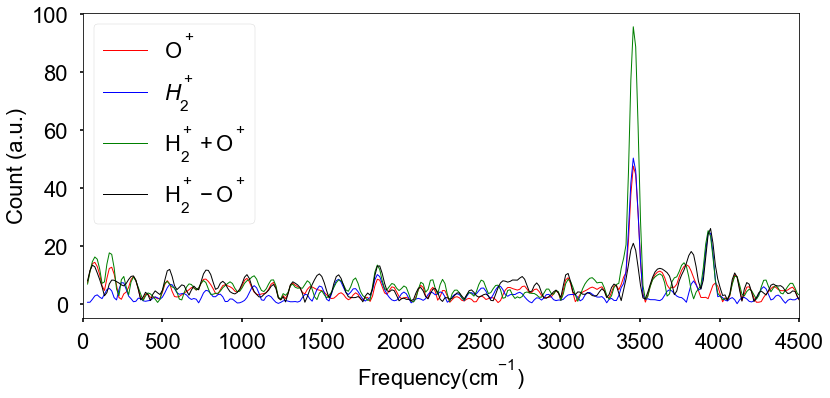

In [34]:
if __name__ == '__main__':
    
    
    for x in ff:

        x.read_split(overNight = False, firstTry =firstTry, sumNo = sumNo, usefulRange = usefulRange, cu=cu)
        x.read_multi()
        x.mass_spectra()
        x.window(windowSize=200, direction='left')
        x.padding(paddingSize=1200)
        x.dataProcess()
        x.show_FFT()
        plt.show()
        